In [1]:
import logging
from utils import logging as lg
lg.set_logging(logging.ERROR)


from skimage.measure import block_reduce
import numpy as np

import logging


from notebook_utils import plot 

from model import base, provider, heatmap_evaluation
import matplotlib.pyplot as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


In [2]:
from utils import data_provider

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped')
}

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [5]:
def count_positive_relevance(model_obj, dataset):
    x = dataset.test2d.x
    y = dataset.test2d.y
    
    rr_inputs = np.zeros((x.shape[0], model_obj.architecture.recur))
    
    with model_obj.get_session() as sess:
        y_pred, y_pred_y_target = sess.run([model_obj.dag.y_pred, model_obj.dag.y_pred_y_target], feed_dict= {
            model_obj.dag.x: x,
            model_obj.dag.y_target: y,
            model_obj.dag.rx: rr_inputs,
            model_obj.dag.keep_prob: 1
        })
        
    relevance = np.sum(y_pred_y_target, axis=1)
    print('Positive relevance for model %s' % model_obj._.experiment_name)
    print('relevance >= 0 : %f' % (np.mean(relevance >= 0)))


# AOPC

In [6]:
def plot_aopc(network, dataset_name, seq, 
              methods=['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_alpha3_beta2', 'lrp_deep_taylor'],
              path=None):
    data = dataset[dataset_name]
    fig = plt.figure(figsize=(20, 6))
    markers = ['o', '^', '*', 's', 's', 'p']
    liss = ['b--', 'g--', 'k--', 'r--', 'y--', 'r']
    ax = fig.add_subplot(121)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    labels = []
    last_values = []
    
    if path is None:
        path = model_path(network, dataset_name, seq)
        

    model_obj = provider.load(path)
    name = base.BaseNetwork.network_nickname(model_obj._.architecture_name)
    test_data = data.test2d.x
    y = data.test2d.y
    
#     test_data = data.test2d.x[:1000, :, :]
#     y = data.test2d.y[:1000, :]
    print('data shape')
    print(test_data.shape)

    count_positive_relevance(model_obj, data)

    relevances = []

    print('dataset %s' % dataset_name)
    for i, m in zip(range(len(methods)), methods):
        print('>> method %s' % m )
        relevance = heatmap_evaluation.aopc(model_obj, test_data, y, method=m, flip_function='minus_one')   

#         apoc =  apoc - apoc_random
        area = np.trapz(relevance, dx=1)
        print('area = %f' % area)

        ax.plot(relevance, liss[i], label=m)
        relevances.append(relevance)
        labels.append(m)
        last_values.append(relevance[-1])

    sorted_indices = np.argsort(-np.array(last_values))

    
    sorted_labels = np.array(labels)[sorted_indices]
    last_values = np.array(last_values)[sorted_indices]
    
    position = np.copy(last_values)

    xticks = range(0, len(relevances[0]), 4)

    plt.ylabel("Average functin value $f(x)$")
    plt.xlabel('perturbation steps')
    plt.legend()
    plt.xticks(xticks)
    plt.title('%s$_{%d}$ : %s ' % (name, seq, dataset_name))

    plt.show()

In [7]:
def plot_aopc_all_dataset( network, methods, seq ):
    for d in ['mnist', 'fashion-mnist']:
        plot_aopc(network, methods, d, seq)

## Shallow

In [8]:
# import imp
# imp.reload(heatmap_evaluation)

# plot_aopc('tutorial_network','mnist', 1,
#           path="../experiment-results/dump/tutorial_network-mnist-seq-1---2018-01-30--23-31-06")

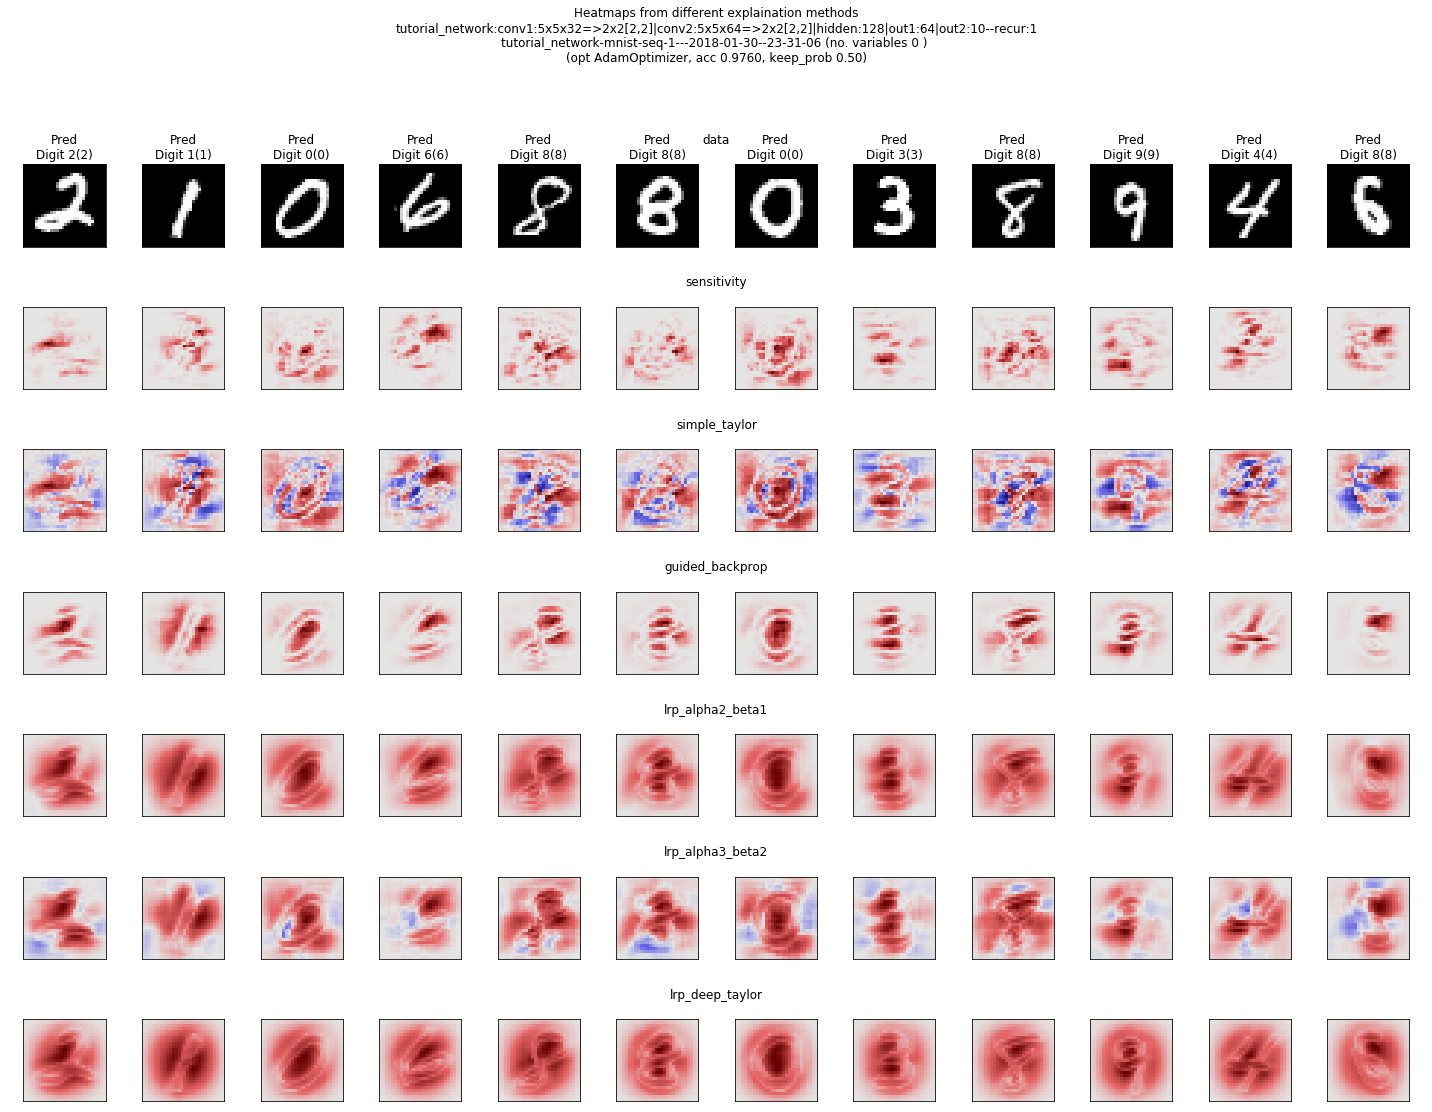

In [9]:
plot.plot_relevance_methods("../experiment-results/dump/tutorial_network-mnist-seq-1---2018-01-30--23-31-06", dataset['mnist']) 

In [ ]:
# # train 50 epoches
# plot_aopc('tutorial_network','mnist', 1,
#           path="../experiment-results/tutorial-network/tutorial_network-mnist-seq-1---2018-01-31--00-30-15")

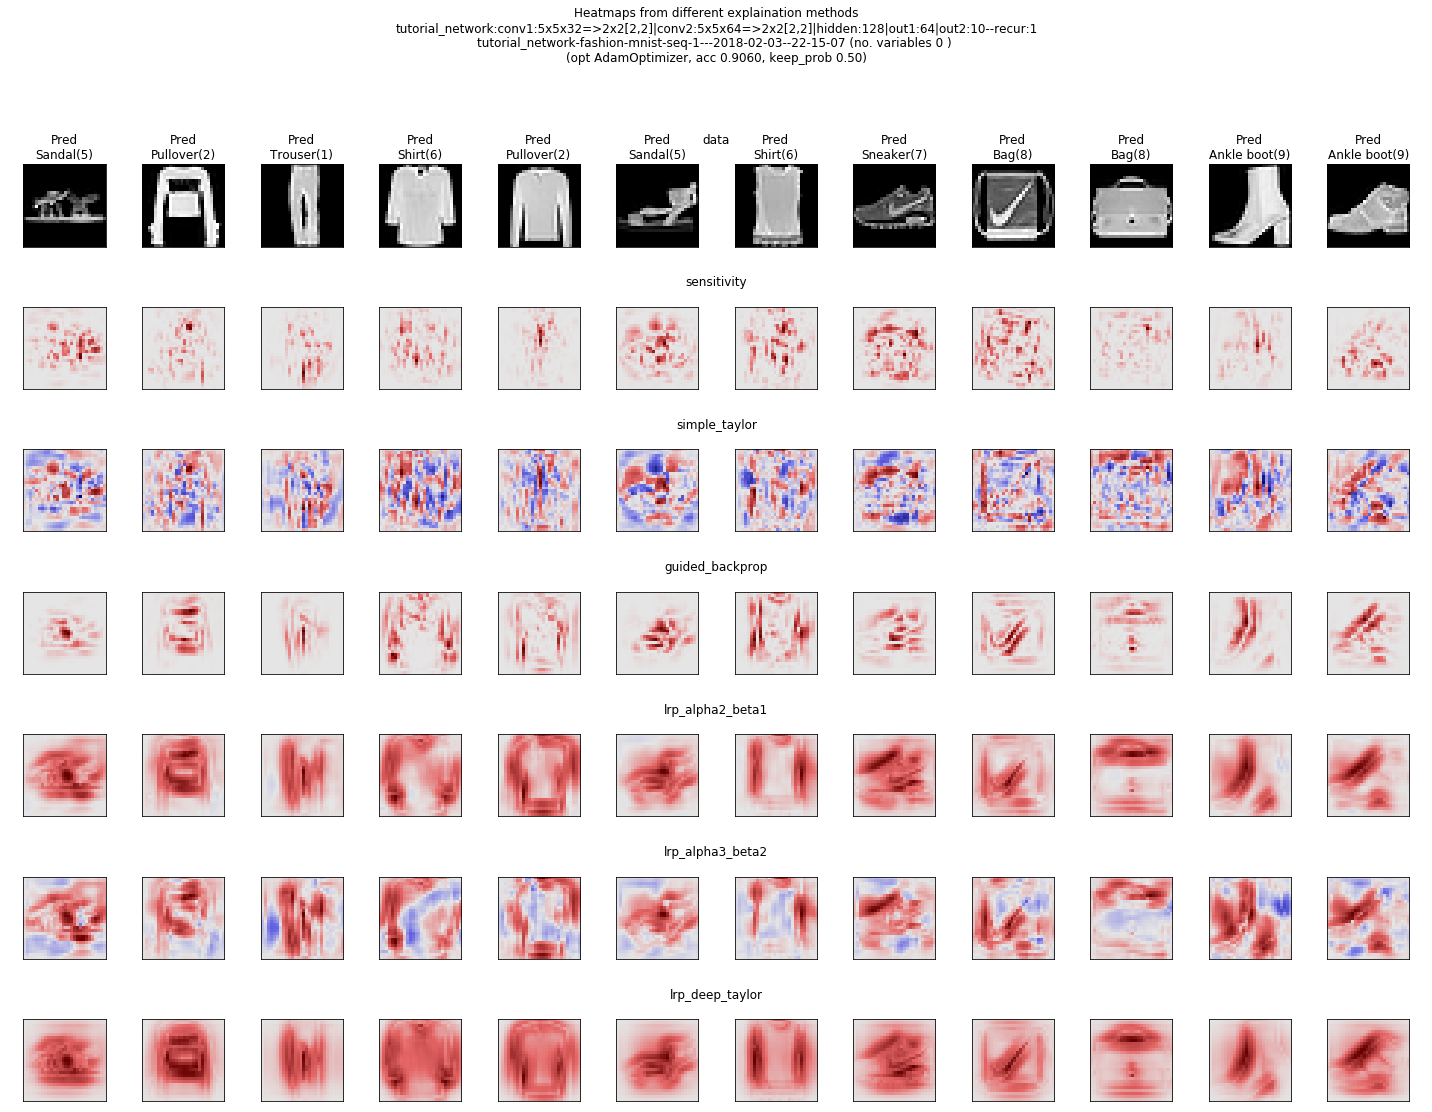

In [11]:
plot.plot_relevance_methods("../final-models/lenet-fashion-mnist", dataset['fashion-mnist']) 

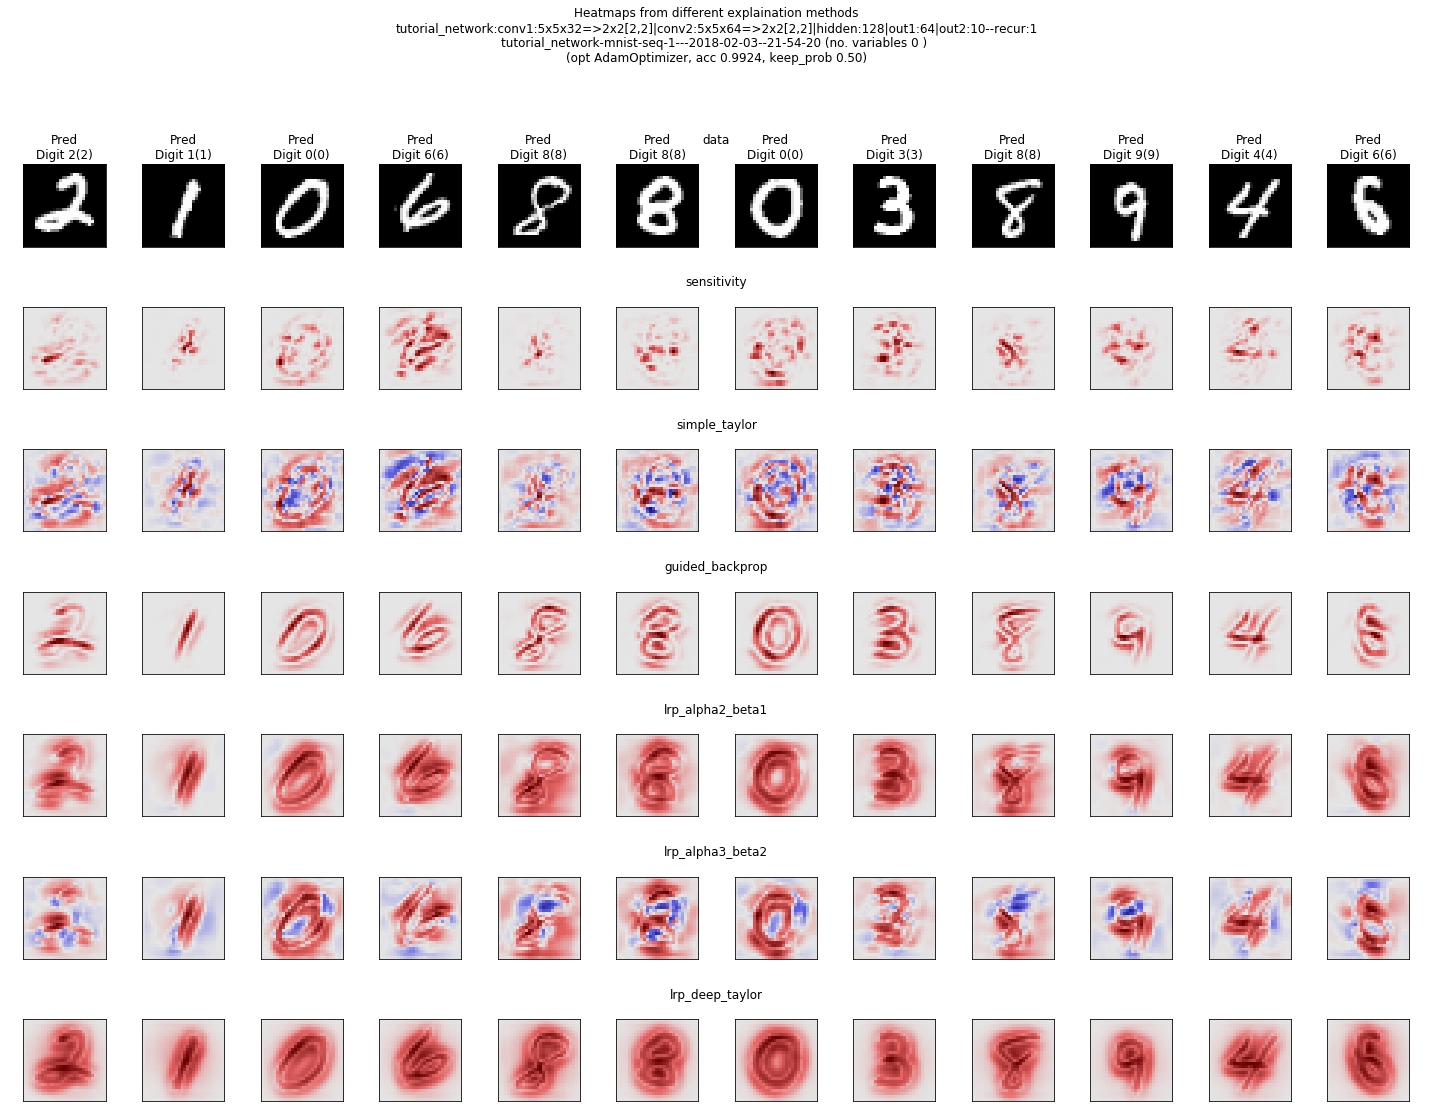

In [12]:
plot.plot_relevance_methods("../final-models/lenet-mnist", dataset['mnist']) 